# Compare models with diff delays

In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [3]:
mouse_id = 'Mouse12'
session_id = '120806'
phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/' 

In [4]:
dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

units_used = dataset_dict['neurons']
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)


rcov = dataset_dict['covariates']
sweep = torch.linspace(0, 2*torch.pi, 100)[None, :]
rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]

units:  85  hdc units:  22


## Full model marginalized down to HD-only

delay -3, LL = -208694.9375
99delay -2, LL = -196029.13504464287
99delay -1, LL = -188915.76785714287
99delay 0, LL = -189694.4720982143
99delay 1, LL = -199973.95982142858
99delay 2, LL = -210440.98549107142
99delay 3, LL = -217992.3950892857
99

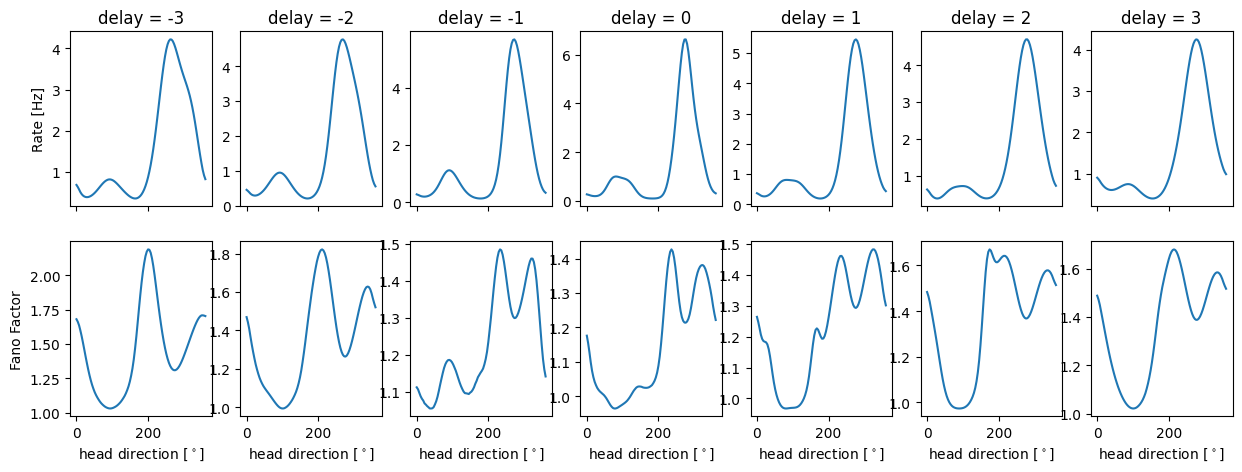

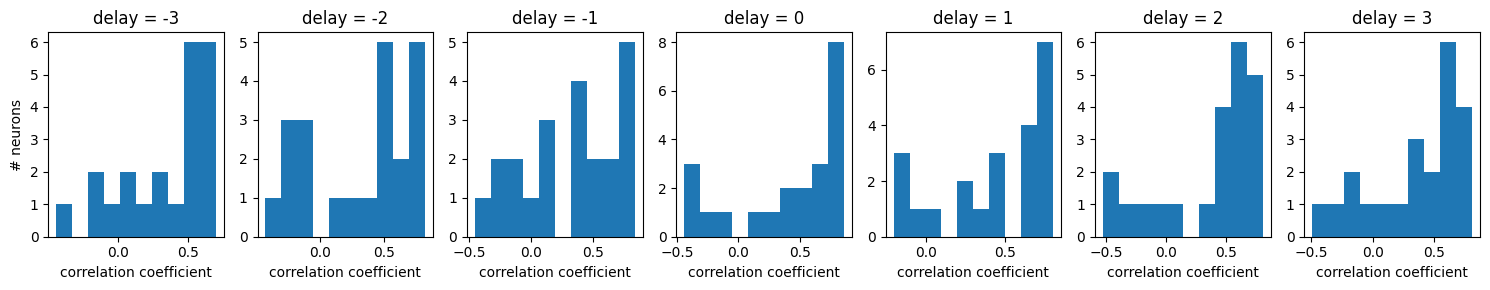

In [62]:
ne=12

delays = [-3, -2, -1, 0, 1, 2, 3]

model_dict['x_mode'] = 'hd-omega-speed-x-y-time'
model_dict['delays'] = delays

angles = np.linspace(0, 360, hd_sweep.shape[-1])

fig1, ax1 = plt.subplots(2, len(delays), figsize = (15,5), sharex=True)
ax1[0, 0].set_ylabel('Rate [Hz]')
ax1[1, 0].set_ylabel('Fano Factor')

fig2, ax2 = plt.subplots(1, len(delays), figsize=(15,3))
ax2[0].set_ylabel('# neurons')
P_mcs = []

for i, delay in enumerate(delays):
    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

    ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
    print(f'delay {delay}, LL = {ll}')
    
    with torch.no_grad():
        P_mc = lib.helper.marginalized_P(
        modelfit, sweep, [list(rcov.keys()).index('hd')],
                                         rcov_matrix, batch_size, list(range(units_used)),
                                         MC=30, skip=3)  # predictive posterior
    P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   
    P_mcs.append(P_mc)
    K = P_mc.shape[-1]
    counts = torch.arange(K)

    hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
    hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
    hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
    hd_FF = hd_var / (hd_mean + 1e-12)

    _, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])  # (neurons, steps)
    _, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])


    ax1[0, i].plot(angles, hd_rate[ne, :])
    ax1[1, i].plot(angles, hd_FF[ne, :])
    ax1[1, i].set_xlabel('head direction [$^\circ$]')
    ax1[0, i].set_title(f'delay = {delay}')


    correlations = np.empty((0,))
    for j in range(units_used):
        C = np.corrcoef(np.gradient(hd_rate[j,:])**2, hd_FF[j,:])
        correlations = np.append(correlations, C[0,1])


    ax2[i].hist(correlations, bins=10)
    ax2[i].set_xlabel('correlation coefficient')
    ax2[i].set_title(f'delay = {delay}')

plt.tight_layout()

delay 0, LL = -189937.0078125
99

Text(0.5, 1.0, 'delay = 0')

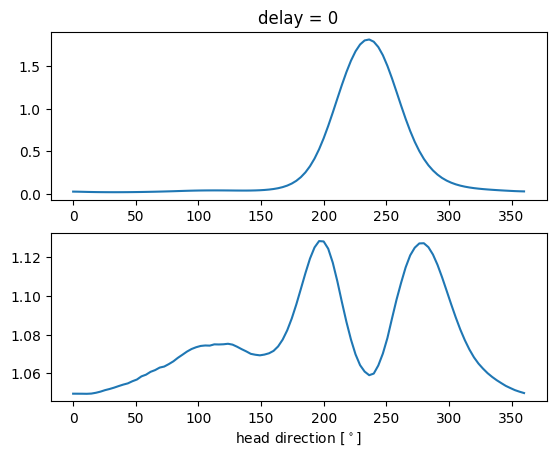

In [8]:
ne=0

model_dict['x_mode'] = 'hd-omega-speed-x-y-time'
model_dict['delays'] = [0]
delay=0

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)


ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
print(f'delay {delay}, LL = {ll}')
    

with torch.no_grad():
    P_mc = lib.helper.marginalized_P(
        modelfit, sweep, [list(rcov.keys()).index('hd')],
                                         rcov_matrix, batch_size, list(range(units_used)),
                                         MC=30, skip=3)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

_, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
_, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(angles, hd_rate[ne, :])
ax1[0].set_ylabel('')
ax1[1].plot(angles, hd_FF[ne, :])
ax1[1].set_xlabel('head direction [$^\circ$]')
ax1[0].set_title(f'delay = {delay}')


# HD-only model

delay -3, LL = -226209.03236607142
delay -2, LL = -218193.18080357142
delay -1, LL = -207650.08370535713
delay 0, LL = -202811.6908482143
delay 1, LL = -211337.79575892858
delay 2, LL = -220660.58705357142
delay 3, LL = -227618.55357142858


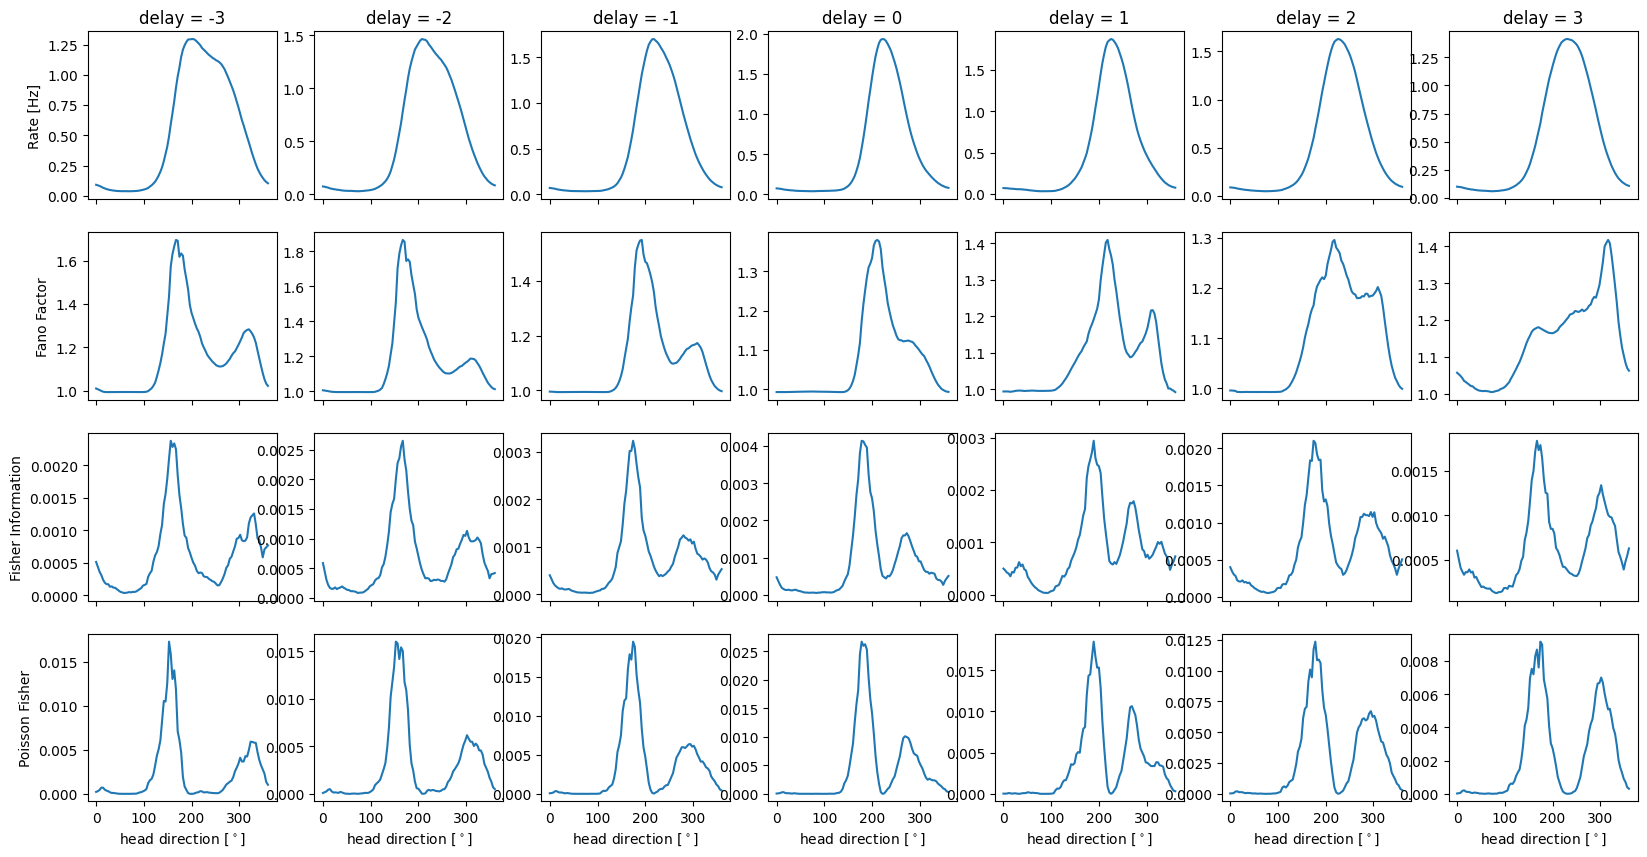

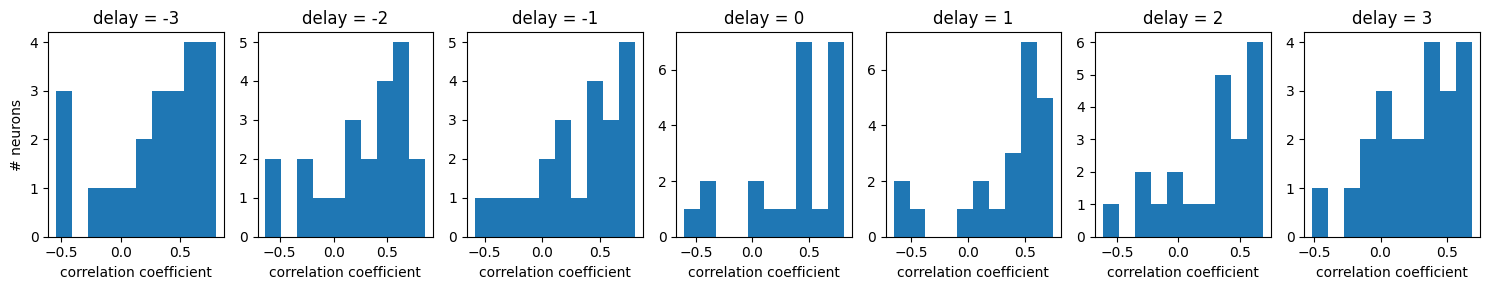

In [6]:
ne=1
hd_sweep = torch.linspace(0, 2*np.pi, 100)

model_dict['x_mode'] = 'hd'
angles = np.linspace(0, 360, hd_sweep.shape[-1])

delays = [-3, -2, -1, 0, 1, 2, 3]
model_dict['delays'] = delays

fig1, ax1 = plt.subplots(4, len(delays), figsize = (20,10), sharex=True)
ax1[0, 0].set_ylabel('Rate [Hz]')
ax1[1, 0].set_ylabel('Fano Factor')
ax1[2, 0].set_ylabel('Fisher Information')
ax1[3, 0].set_ylabel('Poisson Fisher')

fig2, ax2 = plt.subplots(1, len(delays), figsize=(15,3))
ax2[0].set_ylabel('# neurons')

hd_rates = []
P_mcs = []

for i, delay in enumerate(delays):
    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

    ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
    print(f'delay {delay}, LL = {ll}')
    
    covariates=hd_sweep[None, None, :, None]
    with torch.no_grad():
        P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
    P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   

    P_mcs.append(P_mc)

    K = P_mc.shape[-1]
    counts = torch.arange(K)

    hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
    hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
    hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
    hd_FF = hd_var / (hd_mean + 1e-12)

    _, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])  # (neurons, steps)
    _, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

    grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
    grad = grad[0]

    [fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])
    
    fisher_poisson = torch.gradient(hd_rate, dim=1)[0]**2 / hd_rate

    ax1[0, i].plot(angles, hd_rate[ne, :])
    ax1[1, i].plot(angles, hd_FF[ne, :])
    ax1[2, i].plot(angles, fisher[ne, :])
    ax1[0, i].set_title(f'delay = {delay}')
    ax1[3, i].plot(angles, fisher_poisson[ne, :])
    ax1[3, i].set_xlabel('head direction [$^\circ$]')


    correlations = np.empty((0,))
    for j in range(units_used):
        C = np.corrcoef(np.gradient(hd_rate[j,:])**2, hd_FF[j,:])
        correlations = np.append(correlations, C[0,1])


    ax2[i].hist(correlations, bins=10)
    ax2[i].set_xlabel('correlation coefficient')
    ax2[i].set_title(f'delay = {delay}')

plt.tight_layout()